# Using convolution neural network with augmentation to classify fruits
We will use keras library to build a convolution neural network with augmentation to classify fruits into different categories. 

## Importing required packages

In [1]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt
# keras for deep learning
from keras import layers 
from keras import models 
from keras import optimizers 
from keras.preprocessing.image import ImageDataGenerator 
import os, random, shutil # directory operations

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Setting path location for validation, training and testing images and creating folders in the working directory.

We need to specify the location where the data exists. We will also specify different paths for training and testing data sets as the original dataset is not split into training and test dataset. These paths need to be in our working directory.

In [2]:
validationPath = '../input/fruits-360_dataset_2018_06_03/fruits-360/Validation'
trainPathSource = '../input/fruits-360_dataset_2018_06_03/fruits-360/Training'
trainPathDest = '../working/Training'
testPathDest = '../working/Test'

As we will be navigating directories alot, it will be much easier to create a function which gets us to the working directory.

In [3]:
def get2working():
    while True:
        if os.getcwd() == '/kaggle/working':
            break
        elif os.getcwd() == '/':
            os.chdir('kaggle/working')
        else:
            os.chdir('..')

Another function that will help us is for creation of folders given a path as the input to this function.

In [4]:
def createfolder(pathandname):
    get2working()
    try:
        os.mkdir(pathandname)
        print('Folder created')
    except FileExistsError:
        print('Folder already exists so command ignored')

Now let's create folders for training and testing data in our working directory. We will store training and testing data in these directories. These need to be created in the working directory as kaggle only allows us to write to this directory.

In [5]:
createfolder(testPathDest)
createfolder(trainPathDest)

Folder created
Folder created


# Splitting the training data into training and test set.
Now we are ready to access the input directory training data and copy some data from it to the created test folder in our working directory and copying the rest to the training folder in our working directory.

In [6]:
get2working() # Changing path to working directory
os.chdir(trainPathSource) # Changing path to input training folder
fruitnames = [file for file in os.listdir()]; # Storing names of fruits (sub folders within the training folder) in a list
# Looping over the list of fruit names
for fruit in fruitnames:
    get2working() # Changing path to working directory
    testpath = os.path.join(testPathDest,fruit) # Creating path for a specifc fruit for the output test folder
    trainpath = os.path.join(trainPathDest,fruit) # Creating path for a specifc fruit for the output training folder
    sourcepath = os.path.join(trainPathSource,fruit)  # Creating path for a specifc fruit for the source folder
    os.mkdir(testpath) # Creating a folder for a specific fruit in the test directory
    os.mkdir(trainpath) # Creating a folder for a specific fruit in the training directory
    os.chdir(sourcepath) # Changing path to the source directory
    randomsample = random.sample(os.listdir(),len(os.listdir())) # Sampling random fruit images for a certain fruit
    get2working() # Changing path to the working directory
    # Copying the first 25% fruit images from the source folder (randomaly sampled already) and copying them to the test folder 
    for k in range(0,len(randomsample)//4):
        shutil.copy(os.path.join(sourcepath,randomsample[k]),testpath)
    # Copying the rest of fruit images from the source folder (randomaly sampled already) and copying them to the training folder
    for k in range(len(randomsample)//4,len(randomsample)):
        shutil.copy(os.path.join(sourcepath,randomsample[k]),trainpath)

## Building and compiling the convolution neural network
Now that our data has been split into training and test sets, we can build our covnet. We will use a number of convolution + max pooling layers. At the end we will add a flatten layer and a drop out layer followed by a dense layer. Lastly, as we have multiple classification labels we will use sofmax activation for our output layer and the size of the output will be set to the length of the fruitnames list we generated in the last part. We do this as the dataset is constantly being updated with new classes. 

Building the covnet

In [7]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), 
                        activation='relu', 
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), 
                        activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), 
                        activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), 
                        activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten()) # adding a flatten layer and a dropout layer
model.add(layers.Dropout(0.5)) # adding a dropout layer
model.add(layers.Dense(512, 
                       activation='relu')) # adding a dense layer
model.add(layers.Dense(len(fruitnames), 
                       activation='softmax')) # adding the final layer with 60 outputs(target size) and softmax activation

In [8]:
# Checking the model architecture
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

Now we compile the model using accuracy as our metric and categorical crossentropy as the loss function as we have multiple classes.

In [9]:
# Compiling the model with categorical crossentropy for multiclass labels
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

# Getting data ready for fitting to the model.
We will use ImageDataGenerator to get the data ready for input to our model. Importantly, we will add image rotation, shear etc for augmentation. Another important point is to ensure that this transformation is not performed for the test and validation images. 

In [10]:
# Making an image data generator object with no augmentation for validation and testing
test_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
# Making an image data generator object with augmentation for training
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

In [12]:
# Using the generator with batch size 32 for training directory with augmentation
train_generator = test_datagen.flow_from_directory(trainPathDest,
                                                        target_size=(150, 150),
                                                        batch_size=32,
                                                        class_mode='categorical')

Found 24342 images belonging to 65 classes.


In [13]:
# Using the generator with batch size 17 for validation directory
validation_generator = test_datagen.flow_from_directory(validationPath,
                                                        target_size=(150, 150),
                                                        batch_size=17,
                                                        class_mode='categorical')

Found 10903 images belonging to 65 classes.


## Fitting the model
Now we are ready to fit the model. We need to calculate 2 numbers: steps_per_epoch and validation_steps. We calculate these by dividing the total number of images by the batch size and rounding off to the smallest value. For steps_per_epoch this will be np.floor(number of training images / training batch size) and for validation_steps this will be np.floor(number of validation images / validation batch size)

In [14]:
steps_per_epoch = np.floor(24342/32).astype(int)
validation_steps = np.floor(10903/17).astype(int)

In [15]:
# Fitting the model using the train_generator
history = model.fit_generator(train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=25,
                              validation_data=validation_generator,
                              validation_steps=validation_steps)

Epoch 1/25
760/760 [==============================] - 72s 94ms/step - loss: 1.2786 - acc: 0.6326 - val_loss: 0.5005 - val_acc: 0.8467
Epoch 2/25
760/760 [==============================] - 58s 76ms/step - loss: 0.1976 - acc: 0.9380 - val_loss: 0.3572 - val_acc: 0.9135
Epoch 3/25
760/760 [==============================] - 58s 76ms/step - loss: 0.0871 - acc: 0.9730 - val_loss: 0.3041 - val_acc: 0.9186
Epoch 4/25
760/760 [==============================] - 58s 76ms/step - loss: 0.0568 - acc: 0.9835 - val_loss: 0.1859 - val_acc: 0.9397
Epoch 5/25
760/760 [==============================] - 59s 77ms/step - loss: 0.0424 - acc: 0.9869 - val_loss: 0.1581 - val_acc: 0.9518
Epoch 6/25
760/760 [==============================] - 58s 77ms/step - loss: 0.0378 - acc: 0.9881 - val_loss: 0.1266 - val_acc: 0.9638
Epoch 7/25
760/760 [==============================] - 60s 79ms/step - loss: 0.0280 - acc: 0.9905 - val_loss: 0.1314 - val_acc: 0.9614
Epoch 8/25
760/760 [==============================] - 58s 76ms

## Saving and plotting
We will now save the model. This is important as we can use this model to train related images, for example images of vegetables. As the features for fruits and vegetables are similar we can freeze the top most layers and train the model on vegetables. This will save alot of training time and will require a smaller number of samples. We also need to plot loos and accuracy vs epoch to test for overfitting.

In [16]:
# Saving the model
model.save('Fruit_classification_covnet_augmented_test_split.h5')

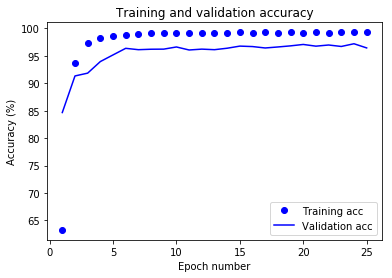

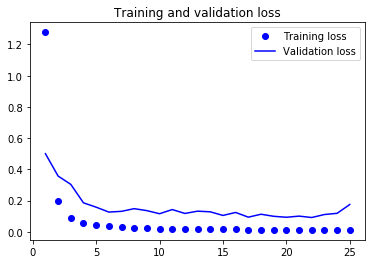

In [17]:
# Plotting loss and accuracy for validation and training data
acc = np.array(history.history['acc'])*100
val_acc = np.array(history.history['val_acc'])*100
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch number')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [18]:
print('Validation accuracy at the last epoch is: {} %'.format(val_acc[-1]))

Validation accuracy at the last epoch is: 96.45774087370279 %


## Model results 
The model gives us a validation accuaracy of 97.4%. Moreover, the plots show that we do not get any overfiting. Now it's time to test the model on the test data set.

In [19]:
# Creating the test_generator
test_generator = test_datagen.flow_from_directory(testPathDest,
                                                  target_size=(150, 150),
                                                  batch_size=20,
                                                  class_mode='categorical')

Found 8084 images belonging to 65 classes.


We use evaluate_generator to test our model on the test data. The steps variable as before will be:
np.floor(8084/20).astype(int)

In [20]:
steps = np.floor(8084/20).astype(int)
test_loss, test_acc = model.evaluate_generator(test_generator, steps=steps)
print('Test accuracy for the model is {} %'. format(test_acc*100))

Test accuracy for the model is 99.18316812208383 %


## Model accuracy for test data
The model gives us an accuracy of 99 % on test data.